In [321]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath("../../nnets"))
from graph import Node, Parameter, display_chain

# Read in our data, and fill missing values
data = pd.read_csv("../../data/clean_weather.csv", index_col=0)
data = data.ffill()

x = data[:10][["tmax", "tmin", "rain"]].to_numpy()
y = data[:10][["tmax_tomorrow"]].to_numpy()

In [322]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w

    def backward(self, grad):
        x, w = self.cache
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        return grad, grad

class MSE(Node):
    def forward(self, pred, actual):
        return pred, (pred - actual) ** 2

    def backward(self, grad):
        pred, actual = self.cache
        return 2 * (pred - actual)

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache
        return grad * exponent * x ** (exponent - 1)

class Subtract(Node):
    def forward(self, x, y):
        return x - y

    def backward(self, grad):
        return grad, -grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        grad[x < 0] = 0
        return grad

In [323]:
w1 = np.random.rand(3, 3)
b1 = np.random.rand(3)
w2 = np.random.rand(3,1)
b2 = np.random.rand(1)

l1 = x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2

loss = 2 * (l2 - y)

l2_w_grad = l1_activated.T @ loss
l2_b_grad = loss.sum(axis=0)

l1_grad = loss @ w2.T
l1_grad[l1 < 0] = 0

l1_w_grad = x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

In [324]:
l1_w_grad

array([[-3.44271499e+03, -7.23866360e+03, -4.17848897e+03],
       [-2.60222161e+03, -5.47143953e+03, -3.15836610e+03],
       [-3.55634473e+00, -7.47758186e+00, -4.31640356e+00]])

In [325]:
X = Parameter(x, desc="X", needs_grad=False)
Y = Parameter(y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

sub = Subtract(add2, Y, out="p - y")
square = Parameter(2, desc="2", needs_grad=False)
pow = Pow(sub, square, out="L")
loss = pow.apply_fwd()

In [326]:
mse = MSE(add2, Y, out="L")
pred, loss_mse = mse.apply_fwd()

np.allclose(loss, loss_mse)

True

In [327]:
np.allclose(l2, pred)

True

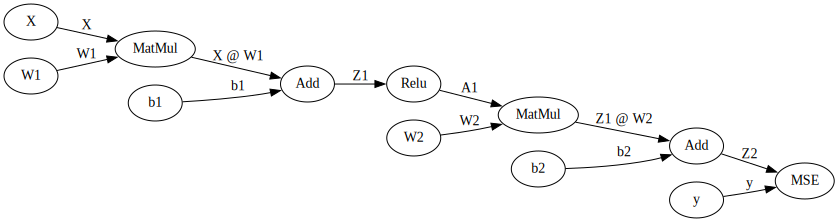

In [328]:
mse.generate_graph()

In [329]:
mse.zero_grad()
mse.apply_bwd(1)

np.allclose(l1_w_grad, w1_param.grad)

True

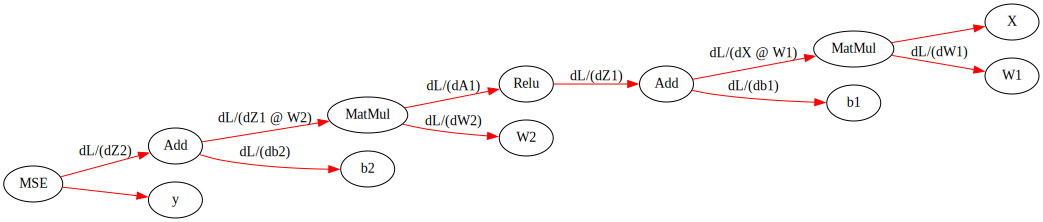

In [330]:
mse.generate_graph(backward=True)

In [331]:
mse.generate_derivative_chains()

In [332]:
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>